      r1t   r3t
0    2.36  2.51
1    2.48  2.72
2    2.45  2.74
3    2.38  2.62
4    2.28  2.58
..    ...   ...
607  1.34  2.45
608  1.31  2.44
609  1.24  2.27
610  1.24  2.25
611  1.19  2.00

[612 rows x 2 columns]


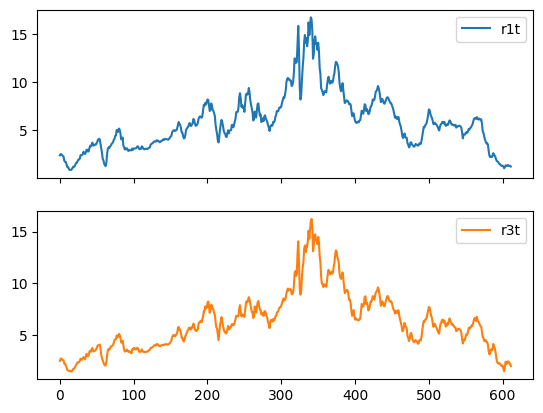

In [6]:
#1.
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# 讀取資料集
data = pd.read_csv('C:/Users/user/OneDrive/文件/時間序列/Dataset-InterestRate.txt', delimiter='\s+', header=None)
data.columns = ['r1t', 'r3t', 'year', 'month', 'day']

# 只保留利率資料
data = data[['r1t', 'r3t']]
print(data)
data.plot(subplots=True)
plt.show()

In [7]:
#1.(a) For this problem, use the dataset Dataset-InterestRate.txt. The dataset consists the monthly U.S.
#1-year r1t(first column) and 3-year r3t (second column) Treasury constant maturity rates from April 1953
#to March 2004.

#使用M(i)方法做order estimation
def calculate_mi(data, maxlags):
    T, k = data.shape
    model = VAR(data)
    mi_values = []
    
    for i in range(1, maxlags + 1):
        results_i = model.fit(i)
        results_i_1 = model.fit(i - 1)
        
        sigma_i = np.linalg.det(results_i.sigma_u)
        sigma_i_1 = np.linalg.det(results_i_1.sigma_u)
        
        mi = -(T - k - i - 1.5) * np.log(sigma_i / sigma_i_1)
        mi_values.append(mi)
    
    return mi_values

# 設置最大滯後階數
maxlags = 15
mi_values = calculate_mi(data, maxlags)

# 找到使 M(i) 最小的滯後階數
best_lag_order = np.argmin(mi_values) + 1

# 打印 M(i) 統計量和最佳滯後階數
for i, mi in enumerate(mi_values, 1):
    print(f"M({i}): {mi}")

print(f"Best lag order by M(i): {best_lag_order}")

# 適應最佳滯後階數的VAR模型
var_model = VAR(data).fit(best_lag_order)

# 打印模型摘要
print(var_model.summary())

M(1): 3927.893970308918
M(2): 115.20242617175721
M(3): 39.32316638452046
M(4): 12.364906897923508
M(5): 0.4358225654183984
M(6): 9.610376994794676
M(7): 40.883687879374826
M(8): 1.3058331021702532
M(9): 6.790380225005105
M(10): 12.305243683960231
M(11): -1.3103484680519106
M(12): 6.41441919708738
M(13): 10.13118566936302
M(14): 8.127787863780464
M(15): 6.025653830692439
Best lag order by M(i): 11
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jun, 2024
Time:                     23:28:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.66188
Nobs:                     601.000    HQIC:                  -5.86750
Log likelihood:           143.000    FPE:                 0.00248254
AIC:                     -5.99855    Det(Omega_mle):      0.00230290
--------------------------------------------------------------------
Results for

In [8]:
#1.(b)(10%): How do you check the adequacy of your fitted VAR model? Perform such check under 5 %
# significance level (Hint: There is a multidimensional version LB test called Portmanteau test;
# check that out.)

from statsmodels.stats.diagnostic import acorr_ljungbox
# 獲取模型的殘差
residuals = var_model.resid

# 使用 Portmanteau 檢驗檢查殘差的自相關性
def portmanteau_test(residuals, max_lags):
    lb_value, p_value = acorr_ljungbox(residuals, lags=range(1, max_lags+1), return_df=False)
    return lb_value, p_value

# 進行 Portmanteau 檢驗
max_lags = best_lag_order
for i in range(residuals.shape[1]):
    lb_value, p_value = portmanteau_test(residuals.iloc[:, i], max_lags)
    print(f"Results for residual series {i+1}:")
    for j in range(max_lags):
        print(f"Lag {j+1}: LB Statistic = {lb_value[j]}, p-value = {p_value[j]}")
    print("\n")

# 檢查顯著性水平為 5%
significance_level = 0.05
adequacy = all(p > significance_level for p in p_value)
print(f"Is the VAR model adequate? {'Yes' if adequacy else 'No'}")

Results for residual series 1:
Lag 1: LB Statistic = 0.018427772724822895, p-value = 0.8920197630417502
Lag 2: LB Statistic = 0.06018605461120845, p-value = 0.9703552598143127
Lag 3: LB Statistic = 0.24965978781954343, p-value = 0.9692002773847813
Lag 4: LB Statistic = 0.5349919384988507, p-value = 0.9700063192156404
Lag 5: LB Statistic = 0.8705378305439293, p-value = 0.9723178011584437
Lag 6: LB Statistic = 2.5916192668105245, p-value = 0.8580763947452421
Lag 7: LB Statistic = 4.278112500381003, p-value = 0.7472447997275264
Lag 8: LB Statistic = 4.322174856124177, p-value = 0.8269490619159158
Lag 9: LB Statistic = 4.36554000784904, p-value = 0.8857503580395867
Lag 10: LB Statistic = 5.547651248811169, p-value = 0.8517294034264039
Lag 11: LB Statistic = 21.59016115547969, p-value = 0.02774763903214229


Results for residual series 2:
Lag 1: LB Statistic = 0.010944192745993842, p-value = 0.9166817117852684
Lag 2: LB Statistic = 0.06793486937529164, p-value = 0.9666029818529978
Lag 3: LB

In [10]:
#1.(c)(10%): Use the fitted VAR model to produce 1-step to 12-step ahead forecasts of the interest rates , 
#      assuming that the forecast origin is March 2004.

# 使用擬合的 VAR 模型進行 1-step 到 12-step 預測
forecast_horizon = 12
last_obs = data.values[-best_lag_order:]  # 取得最後的滯後階數觀測值
forecast = var_model.forecast(y=last_obs, steps=forecast_horizon)

# 創建 DataFrame 以更好的展示預測結果
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start='2004-04-01', periods=forecast_horizon, freq='M'), columns=['r1t_forecast', 'r3t_forecast'])

print("1-step 到 12-step 預測結果：")
print(forecast_df)

1-step 到 12-step 預測結果：
            r1t_forecast  r3t_forecast
2004-04-30      1.273325      2.003971
2004-05-31      1.409668      2.141508
2004-06-30      1.536077      2.188143
2004-07-31      1.553079      2.177119
2004-08-31      1.603213      2.238804
2004-09-30      1.617350      2.239556
2004-10-31      1.708137      2.272076
2004-11-30      1.748907      2.301536
2004-12-31      1.746415      2.274404
2005-01-31      1.772142      2.273394
2005-02-28      1.825427      2.318391
2005-03-31      1.900560      2.366828


In [12]:
#1.(d) (10%): We want to know whether the two interest rate series are cointegrated or not.
#What does “cointegrated” means mathematically? What kind of test can you test this?
#Use 5 % significance level to perform the test.
#解釋在pdf檔裡

from statsmodels.tsa.vector_ar.vecm import coint_johansen
# 使用 Johansen 共整合檢驗
def johansen_cointegration_test(data, det_order=0, k_ar_diff=best_lag_order):
    result = coint_johansen(data, det_order, k_ar_diff)
    return result

# 進行 Johansen 共整合檢驗
johansen_result = johansen_cointegration_test(data[['r1t', 'r3t']], det_order=0, k_ar_diff=best_lag_order)

# 打印檢驗結果
trace_statistic = johansen_result.lr1
critical_values = johansen_result.cvt

print("Johansen Cointegration Test")
print("===========================")
for i in range(len(trace_statistic)):
    print(f"Null Hypothesis: {i} cointegration vectors")
    print(f"Test Statistic: {trace_statistic[i]}")
    print(f"Critical Value (5%): {critical_values[i, 1]}")
    print(f"Reject Null Hypothesis: {'Yes' if trace_statistic[i] > critical_values[i, 1] else 'No'}")
    print("---------------------------")

Johansen Cointegration Test
Null Hypothesis: 0 cointegration vectors
Test Statistic: 34.58620769472933
Critical Value (5%): 15.4943
Reject Null Hypothesis: Yes
---------------------------
Null Hypothesis: 1 cointegration vectors
Test Statistic: 6.8169895878927855
Critical Value (5%): 3.8415
Reject Null Hypothesis: Yes
---------------------------


In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# 獲取模型的殘差
residuals = var_model.resid

# 使用 Portmanteau 檢驗檢查殘差的自相關性
def portmanteau_test(residuals, lags):
    lb_value, p_value = acorr_ljungbox(residuals, lags=[lags], return_df=False)
    return lb_value, p_value

# 進行 Portmanteau 檢驗
for i in range(residuals.shape[1]):
    lb_value, p_value = portmanteau_test(residuals.iloc[:, i], lags=best_lag_order)
    print(f"Results for residual series {i+1}:")
    for j in range(best_lag_order):
        print(f"Lag {j+1}: LB Statistic = {lb_value[j]}, p-value = {p_value[j]}")
    print("\n")

# 檢查顯著性水平為 5%
significance_level = 0.05
adequacy = all(p > significance_level for p in p_value)
print(f"Is the VAR model adequate? {'Yes' if adequacy else 'No'}")

Results for residual series 1:
Lag 1: LB Statistic = 4.771796975787636, p-value = 0.9938885334643224


IndexError: index 1 is out of bounds for axis 0 with size 1

In [4]:
# 適應VAR模型
model = VAR(data)
results = model.select_order(maxlags=20)

# 打印最佳滯後階數
print(f"Selected orders by AIC: {results.aic}")
print(f"Selected orders by BIC: {results.bic}")
print(f"Selected orders by HQIC: {results.hqic}")

# 根據AIC選擇的最佳滯後階數
best_lag_order = results.aic

# 適應VAR模型
var_model = model.fit(best_lag_order)

# 打印模型摘要
print(var_model.summary())

Selected orders by AIC: 20
Selected orders by BIC: 3
Selected orders by HQIC: 7
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jun, 2024
Time:                     23:19:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.43124
Nobs:                     592.000    HQIC:                  -5.80191
Log likelihood:           189.347    FPE:                 0.00238640
AIC:                     -6.03841    Det(Omega_mle):      0.00208728
--------------------------------------------------------------------
Results for equation r1t
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.059864         0.047317            1.265           0.206
L1.r1t          1.252890         0.111381           11.249           0.000
L1.r3t

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jun, 2024
Time:                     22:08:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.54403
Nobs:                     573.000    HQIC:                  -5.83117
Log likelihood:           159.139    FPE:                 0.00244283
AIC:                     -6.01481    Det(Omega_mle):      0.00219851
--------------------------------------------------------------------
Results for equation r1t
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.078645         0.047764            1.647           0.100
L1.r1t          1.202740         0.115232           10.438           0.000
L1.r3t          0.395390         0.136941            2.887           0.004
L2.r1t     

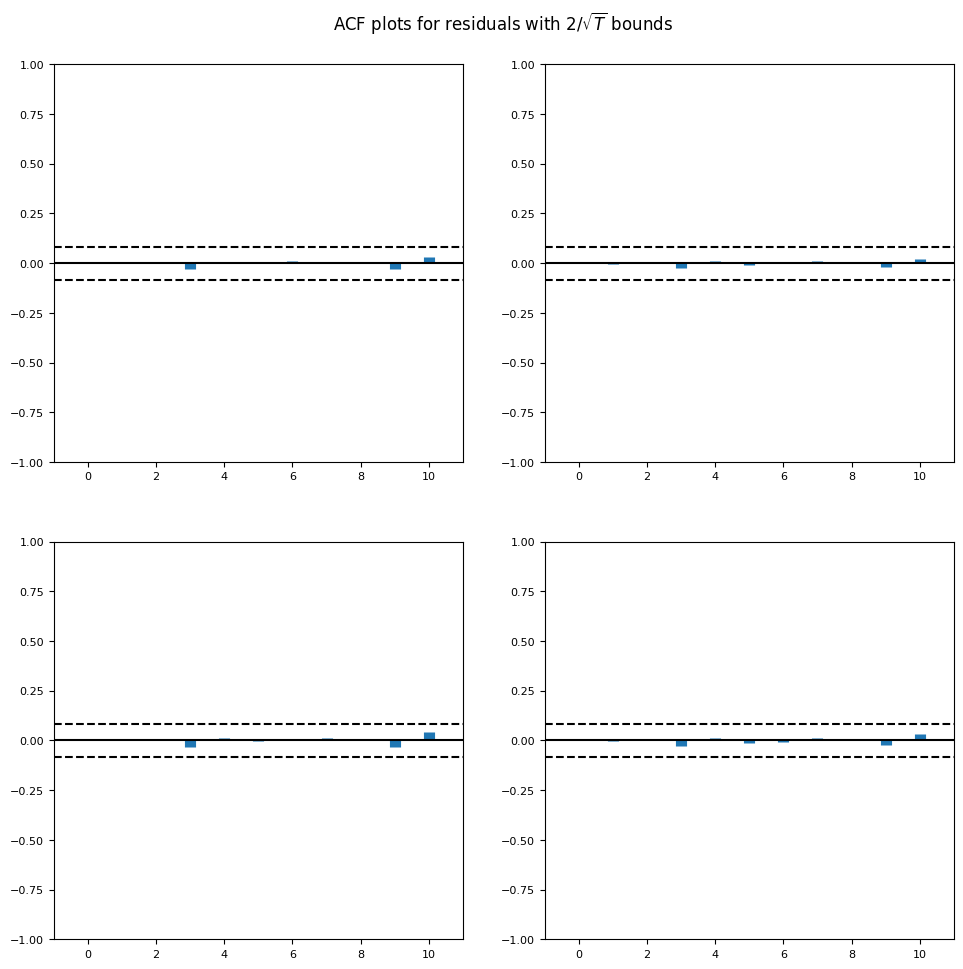

In [4]:
# 拆分訓練和測試集
nobs = 24
train = data[:-nobs]
test = data[-nobs:]

# 適應VAR模型
model = VAR(train)
results = model.fit(maxlags=15, ic='aic')

# 打印適應模型的摘要
print(results.summary())

# 診斷檢查
results.plot_acorr()
plt.show()